In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
cd /content/drive/MyDrive/6.862_MachineLearningProject/BuildingEnergyConsumption/Code

/content/drive/MyDrive/6.862_MachineLearningProject/BuildingEnergyConsumption/Code


In [3]:
# Imports:
import numpy as np
import pandas as pd
import os
from os.path import join
import glob
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from matplotlib.pyplot import figure
import datetime

from load_and_process_data import process_data
from load_electricity_school_data import load_electricity_education
from feature_encoding_and_data_splitting import split_data, prepare_data_simple_encoding, prepare_data_polynomial_encoding
from linear_regression_functions import learn_parameters, plot_loss_history, plot_test_and_prediction, plot_linear_regression_weights


#import sklearn.model_selection
import sklearn.datasets
import sklearn.metrics
from sklearn import tree
from sklearn.ensemble import RandomForestRegressor



import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing

In [4]:
def calculate_rmse_metric(y_pred,y_test):
  return np.sqrt(np.mean((y_pred - y_test)**2))

###General information:
We refer the reader of this notebook to first read the README file on Github and project report that can be found in the Writeup folder.
####Code description:
This is the **main code** for LSTM based predictions for this project. Codes that I used to develop this one is  Development_LSTM.ipynb. 
####Data used:
For this project, as described in project report, I am using electricity consumption predictions only for  buildings whose primary use type is Educational that have very small number of missing consumption data. To extend this to different types of buildings (e.g. offices) I would do one-hot encoding for the primary_use feature. 

####Aim of this code:
Using this code I would like to understand how good of a prediction of future consumption one could make with LSTM based model. In this code I will first make a benchmark by looking at results provided by plain LSTM model, and later I will test CNN-LSTM model with encoder-decoder architecture.

### 1. Load data:

I use the process_data function to load all the data from datafolder. This function also handles missing feature data. The breakdown of missing information for different features is given below: 
<br>

**Building features**:
* 53.4% of the year built
* 75.5% of the floor count

**Weather features**
* 9.5% of the cloud coverage
* 0.1% of the dew temperature
* 36.0% of the precipitation depth
* 7.6% of the sea level pressure
* 4.5% of the wind speed
* 0.2% of the wind direction.

In order to have the largest amount of data on which our model can learn, I filled all the missing information for the above mentioned featues. 
* For the **weather data** features, I filled the missing data by taking the average of the closest non missing values of that feature. My reasoning was that weather data changes slowly enough that missing feature values should have values close to the neighbouring non-missing values.
* For the **building data** I filled the missing data for the feature with the mean of that feature for that building's primary use group. My reasoning was that all the buidlings with the same primary use will have similar number of floors and that they could all be built at the similar time.

After this processing I use load_electricity_education function to load only electricity consumption data on educational buildings that have small number of missing consumption data. After this function I end up working with electricity consumption data over one year period for 118 buildings.

In [5]:
# In colab import files like:
datafolder = '../Data/ashrae-energy-prediction/'
pd_all = process_data(datafolder)
# Load all Education buildings Electricity consumption data that has good 
# electricity meter reading values:
pd_educational = pd_all.copy()
pd_educational = pd_educational.loc[(pd_educational["meter"]==0)]
pd_educational = pd_educational.loc[(pd_educational["primary_use"]=='Education')]
# Load all building_ids that have bad meter_reading and remove this data from our DataFrame:
drop_ids = np.loadtxt('dropids.txt')
pd_educational = pd_educational[~pd_educational.building_id.isin(drop_ids)]
# Choose features we care about:
features = ['building_id','square_feet','year_built','floor_count','timestamp','air_temperature','cloud_coverage','dew_temperature',
            'precip_depth_1_hr','sea_level_pressure','wind_direction','wind_speed','meter_reading']
pd_educational = pd_educational[features]

#### 1.1 Further cleaning and data normalization:

In [6]:
# DATA CLEANUP:
# some of the buildings in pd_educational still have bad readings 
# at the begining of the year, and I will use THRES value to take out 
# only last 8000 points of the year which would correspond to ~11 months of data
pd_edu_clean = pd.DataFrame()
all_dfs = []
THRES = 8000 
for bldg_id in pd_educational.building_id.unique():
    building = pd_educational[pd_educational.building_id == bldg_id]
    if len(building.timestamp.values) > THRES:
      all_dfs.append(pd_educational[pd_educational.building_id == bldg_id][-THRES:])
pd_edu_clean = pd.concat(all_dfs)

# DATA NORMALIZATION:
# Normalize only numeric columns using only data that will be used for training
# Test data will be data from month of December 2016, and training data is the data 
# from begining of the 2016 up to December:
features_norm = ['square_feet','year_built','floor_count','air_temperature','cloud_coverage','dew_temperature',
            'precip_depth_1_hr','sea_level_pressure','wind_direction','wind_speed','meter_reading']
pd_help = pd_edu_clean.copy()
pd_train = pd_help.loc[pd.to_datetime(pd_help["timestamp"]) < datetime.datetime(2016, 12, 1)]
train_mean = pd_train[features_norm].mean()
train_std = pd_train[features_norm].std()

pd_edu_clean[features_norm] = (pd_edu_clean[features_norm] - train_mean)/train_std

### 2. Prepare data for LSTM input:
For input data for LSTM model I used sequence of 24h consumption, building and weather features data prior to the time at which we want to make our prediction. A visual depiction of how the input data was shaped is given in Figure below:
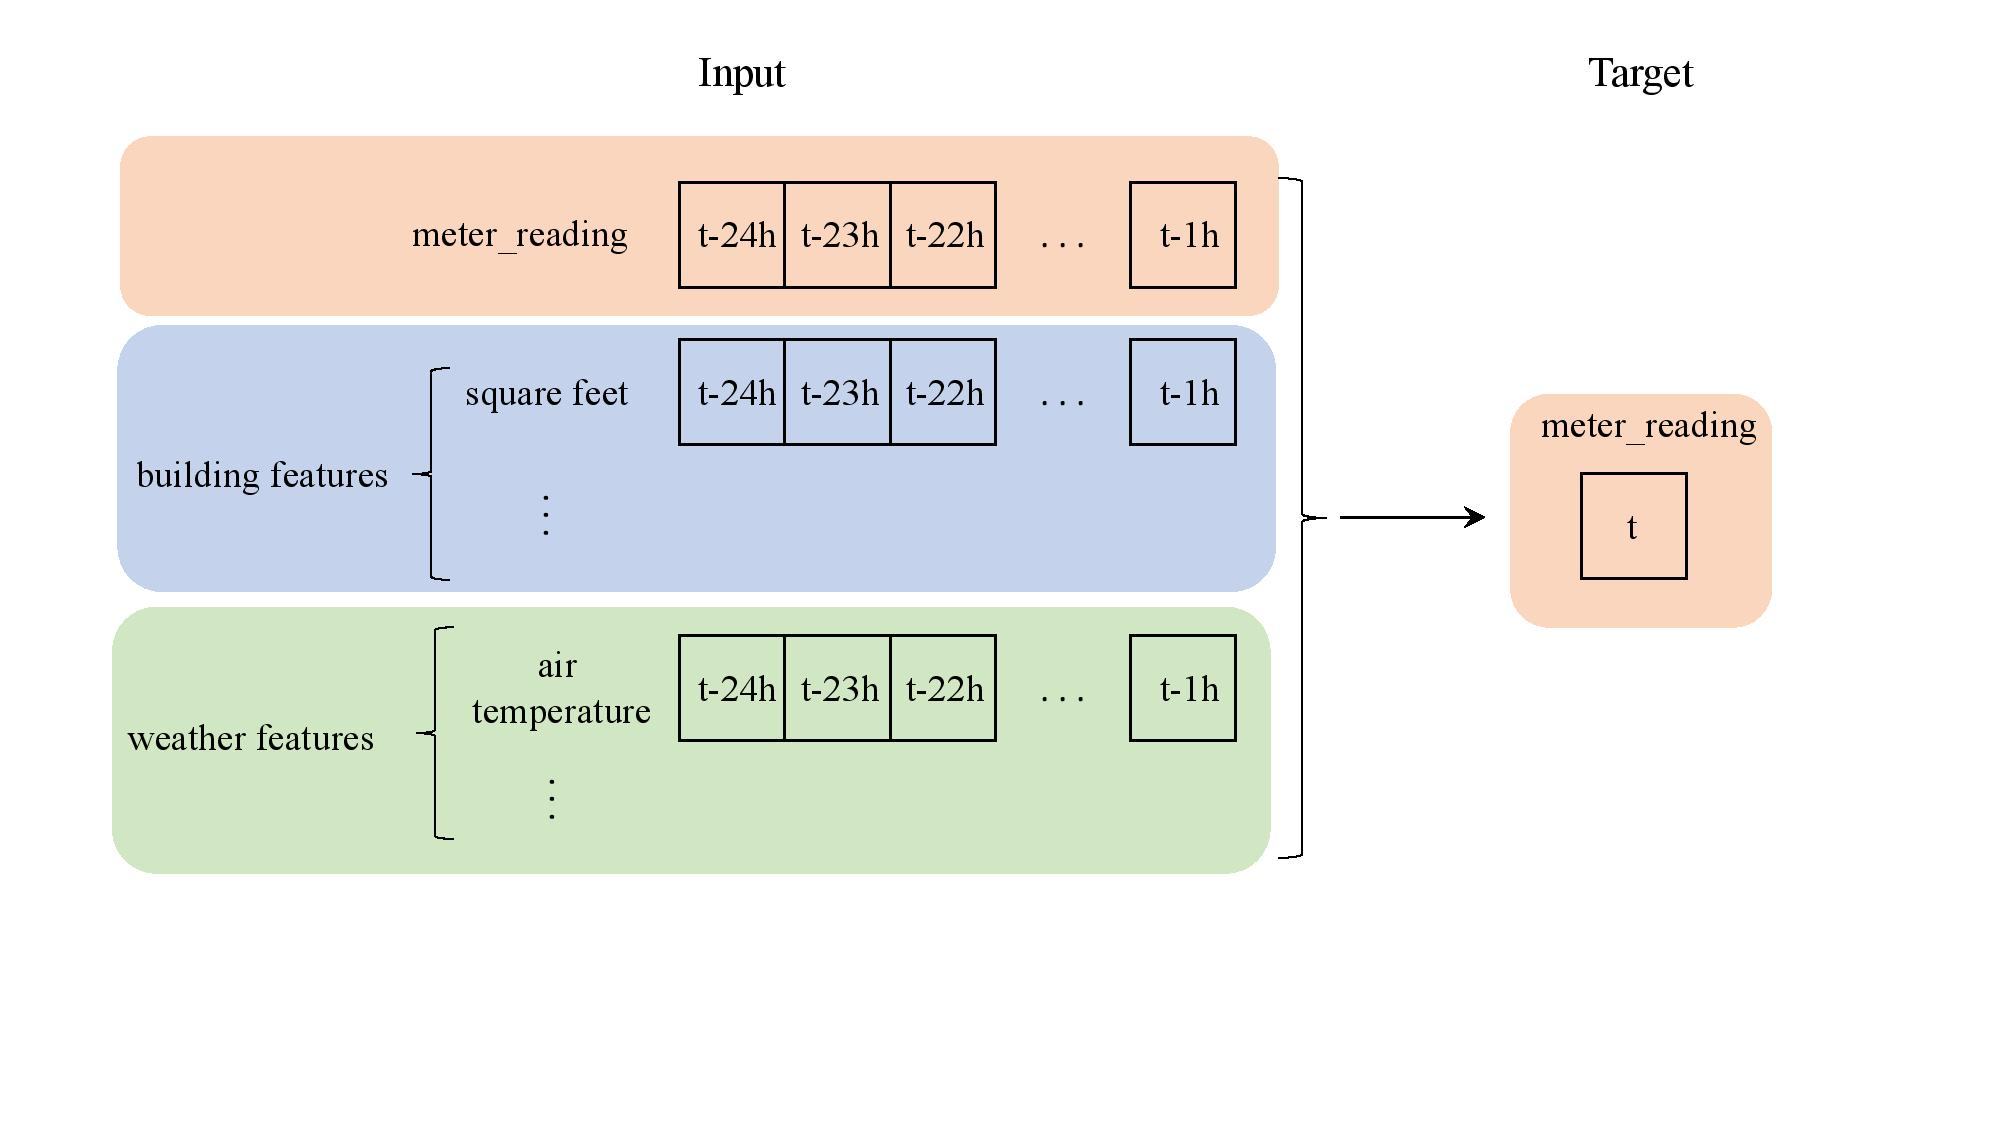

In [7]:
# Use December as a test data and rest of the months are training:
test_size = 24*31 - 1
def prepare_for_LSTM_with_memory(pd, input_features, target, days_in = 1):
  days_in_points = days_in*24
  features_per_sample_train = []
  target_per_sample_train = []
  features_per_sample_test = []
  target_per_sample_test = []
  all_features = input_features.copy()
  all_features.extend(target)
  for bldg_id in pd.building_id.unique():
    building = pd[pd.building_id == bldg_id]
    features_per_sample = []
    target_per_sample = []
    for i in range(len(building.timestamp)- days_in_points):
      features_per_sample.append(np.array(np.float32(building[all_features][i:i+days_in_points])))
      target_per_sample.append(np.array(np.float32(building[target][i+days_in_points:i+days_in_points+1])))
    features_per_sample_train.extend(features_per_sample[:-test_size])
    features_per_sample_test.extend(features_per_sample[-test_size:])
    target_per_sample_train.extend(target_per_sample[:-test_size])
    target_per_sample_test.extend(target_per_sample[-test_size:])
  return (np.stack(features_per_sample_train),np.stack(features_per_sample_test), np.array(target_per_sample_train),np.array(target_per_sample_test))

In [8]:
# Names of columns for input features we will use for leaning as well as target feature 
input_features = ['square_feet','year_built','floor_count','air_temperature','cloud_coverage','dew_temperature',
            'precip_depth_1_hr','sea_level_pressure','wind_direction','wind_speed']
target = ['meter_reading']

train_x, test_x, train_y, test_y = prepare_for_LSTM_with_memory(pd_edu_clean,input_features,target,days_in=1)

### 3. Plain LSTM model:

For plain LSTM model, I used single hidden LSTM layer with 200 units, followed by fully connected layer with 200 nodes and Relu activation that is intended to interpret the features extracted by LSTM model. This is then followed by another fully connected layer that will provide output sequence we are interested in.

#### 3.1. Make model:

In [ ]:
num_features = train_x.shape[2]
timesteps = train_x.shape[1]
# Let's make a model:
lstm_model = tf.keras.Sequential([
      tf.keras.layers.LSTM(units=200, activation='relu', # units is the number of hidden states
          input_shape = (timesteps, num_features),
          return_sequences = True) ,
      tf.keras.layers.Dense(200) ,
      tf.keras.layers.Dense(1)

])

lstm_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.00005),#5e-4),
              loss=keras.losses.MeanSquaredError(),
              metrics=[tf.keras.metrics.MeanSquaredError()])

In [ ]:
lstm_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 24, 200)           169600    
_________________________________________________________________
dense_4 (Dense)              (None, 24, 200)           40200     
_________________________________________________________________
dense_5 (Dense)              (None, 24, 1)             201       
Total params: 210,001
Trainable params: 210,001
Non-trainable params: 0
_________________________________________________________________


#### 3.2. Train model:

In [ ]:
history = lstm_model.fit(train_x, train_y, 
                         batch_size = 1024,
          epochs=10, 
          verbose = 1,
          callbacks=tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3))

Epoch 1/10
672/672 [==============================] - 61s 89ms/step - loss: 0.3532 - mean_squared_error: 0.3532
Epoch 2/10
672/672 [==============================] - 60s 89ms/step - loss: 0.0820 - mean_squared_error: 0.0820
Epoch 3/10
672/672 [==============================] - 60s 89ms/step - loss: 0.0589 - mean_squared_error: 0.0589
Epoch 4/10
672/672 [==============================] - 60s 89ms/step - loss: 0.0464 - mean_squared_error: 0.0464
Epoch 5/10
672/672 [==============================] - 60s 89ms/step - loss: 0.0410 - mean_squared_error: 0.0410
Epoch 6/10
672/672 [==============================] - 60s 89ms/step - loss: 0.0388 - mean_squared_error: 0.0388
Epoch 7/10
672/672 [==============================] - 60s 89ms/step - loss: 0.0361 - mean_squared_error: 0.0361
Epoch 8/10
672/672 [==============================] - 60s 89ms/step - loss: 0.0345 - mean_squared_error: 0.0345
Epoch 9/10
672/672 [==============================] - 60s 89ms/step - loss: 0.0331 - mean_squared_error:

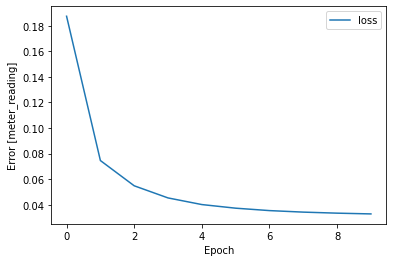

In [ ]:
def plot_loss(history):
    plt.plot(history.history['loss'], label='loss')
    plt.xlabel('Epoch')
    plt.ylabel('Error [meter_reading]')
    #plt.ylim((0,500))
    plt.legend()
plot_loss(history)

#### 3.3. Evaluate the model:

In [ ]:
lstm_model.evaluate(
    test_x,
    test_y, verbose=1)

2206/2206 [==============================] - 32s 14ms/step - loss: 0.0136 - mean_squared_error: 0.0136


[0.013643975369632244, 0.013643981888890266]

#### 3.4. Make prediction 1h in advance:

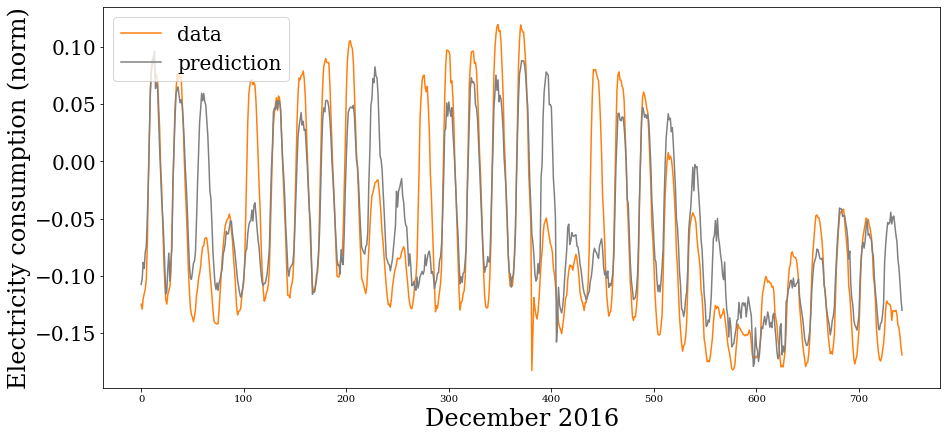

In [ ]:
y_hat_lstm = lstm_model.predict(test_x)
y_hat_last = y_hat_lstm[:,0,:]
y_hat_last.shape

newarr = np.array_split(test_y[:,0,0], 95)
two_blds = np.mean(newarr, axis = 0)
newarrp = np.array_split(y_hat_last[:,0], 95)
two_bldsp = np.mean(newarrp, axis = 0)

plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times New Roman'] + plt.rcParams['font.serif']
figure(figsize =(15,7)) 
plt.plot(two_blds, color = 'C1', label = 'data')
plt.plot(two_bldsp, color = 'gray', label = 'prediction') 
plt.xlabel('December 2016', fontsize = 24)
plt.ylabel('Electricity consumption (norm)', fontsize = 24)
plt.xticks(None)
plt.yticks(fontsize = 20)
plt.legend( fontsize = 20, loc = 'upper left')
#plt.savefig('LSTM_simple.pdf', transparency = True,bbox_inches='tight')
plt.show()

##### Calculate metric for this case:

In [ ]:
test_data = two_blds
prediction = two_bldsp[:len(two_blds)]
calculate_rmse_metric(test_data,prediction)

0.046596173

#### 3.5 Make prediction 12h in advance:

In [18]:
# make function make prediction:
def make_prediction(test_x, model,n_ahead):
  yhat = []
  X = test_x.copy()
  for _ in range(n_ahead):
    fc = model.predict(X)
    yhat.append(fc[:,0,0])

    helper_X = X[:,:,3]
    for sample in range(0,X.shape[0],n_ahead):
      for idx in range(23):
        X[sample,idx,3] = helper_X[sample,idx+1]
      X[sample,-1,3] = fc[sample,0,0]
  yhat = np.array(yhat)
  newarr1 = np.array_split(yhat[:,:], 95, axis = 1) # for 95 buildings we have
  all_blds = np.mean(newarr1,axis = 0)

  yhat_tot = []
  for i in range(0,all_blds.shape[1],n_ahead):
    yhat_tot.extend(all_blds[:,i])

  return np.array(yhat_tot)

In [ ]:
yhat_tot = make_prediction(test_x, lstm_model,n_ahead = 12)
yhat_tot.shape

(744,)

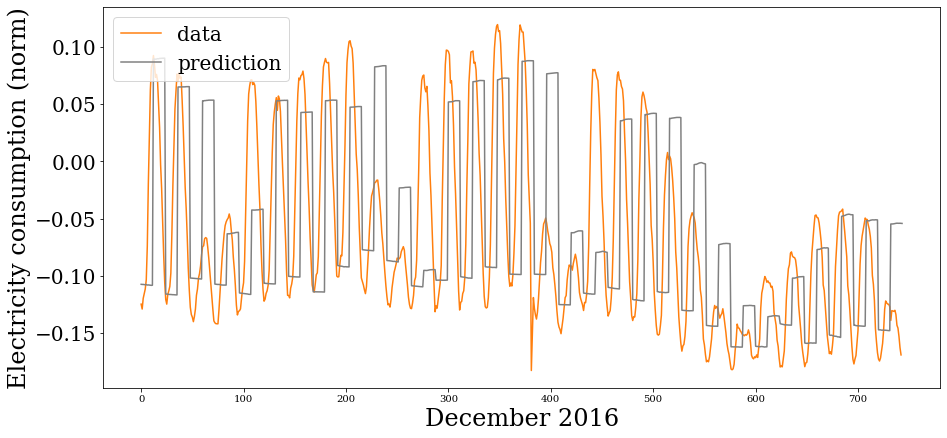

In [ ]:
newarr = np.array_split(test_y[:,0,0], 95)
two_blds = np.mean(newarr, axis = 0)
two_bldsp = yhat_tot
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times New Roman'] + plt.rcParams['font.serif']
figure(figsize =(15,7)) 
plt.plot(two_blds, color = 'C1', label = 'data')
plt.plot(two_bldsp, color = 'gray', label = 'prediction') 
plt.xlabel('December 2016', fontsize = 24)
plt.ylabel('Electricity consumption (norm)', fontsize = 24)
plt.xticks(None)
plt.yticks(fontsize = 20)
plt.legend( fontsize = 20, loc = 'upper left')
#plt.savefig('LSTM_simple.pdf', transparency = True,bbox_inches='tight')
plt.show()

##### Calculate metric for this case:

In [ ]:
test_data = two_blds
prediction = two_bldsp[:len(two_blds)]
calculate_rmse_metric(test_data,prediction)

0.0885327

#### 3.6. Make prediction 24h in advance:

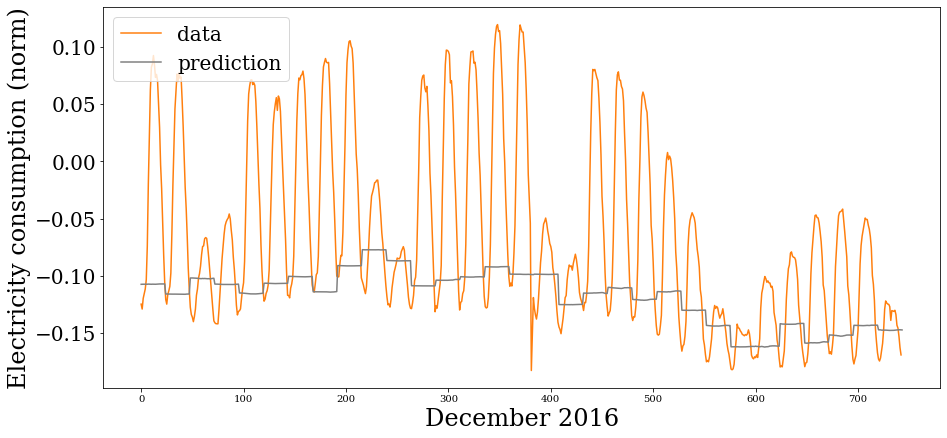

In [ ]:
yhat_tot = make_prediction(test_x, lstm_model,n_ahead = 24)
newarr = np.array_split(test_y[:,0,0], 95)
two_blds = np.mean(newarr, axis = 0)
two_bldsp = yhat_tot
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times New Roman'] + plt.rcParams['font.serif']
figure(figsize =(15,7)) 
plt.plot(two_blds, color = 'C1', label = 'data')
plt.plot(two_bldsp, color = 'gray', label = 'prediction') 
plt.xlabel('December 2016', fontsize = 24)
plt.ylabel('Electricity consumption (norm)', fontsize = 24)
plt.xticks(None)
plt.yticks(fontsize = 20)
plt.legend( fontsize = 20, loc = 'upper left')
#plt.savefig('LSTM_simple.pdf', transparency = True,bbox_inches='tight')
plt.show()

##### Calculate metric for this case:

In [ ]:
test_data = two_blds
prediction = two_bldsp[:len(two_blds)]
calculate_rmse_metric(test_data,prediction)

0.09006436

### 4. CNN-LSTM:
In this part, I used CNN-LSTM model based on encoder-decoder architecture. Encoder of the data was comprised of two convolutional layers followed by a max pooling layer, the results of which were then flattened. The first convolutional layer takes input sequence and extracts output that extracts certain features of the input. These features are then fed as input into the second convolutional layer that is trying to amplify any salient features. I used 64 filters for both convolutional layers with kernel size of three time steps. After convolutional layers I used max pooling layer with pool size of 2 to simplify the extracted features and keep only 25\% of them with largest signal values. These extracted features were then sent to decoder part of the model. The decoder of the architecture was made out of single hidden LSTM layer with 200 units, followed by fully connected layer with 100 nodes and Relu activation function. Finally at the end I added one more fully connected layer whose output will provide the sequence we are interested in.

#### 4.1. Make model:

In [9]:
n_features = train_x.shape[2]
n_timesteps = train_x.shape[1]
n_outputs = train_y.shape[1]
  
cnn_lstm_model = tf.keras.Sequential()
cnn_lstm_model.add(tf.keras.layers.Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(n_timesteps,n_features)))
cnn_lstm_model.add(tf.keras.layers.Conv1D(filters=64, kernel_size=3, activation='relu'))
cnn_lstm_model.add(tf.keras.layers.MaxPooling1D(pool_size=2))
cnn_lstm_model.add(tf.keras.layers.Flatten())
cnn_lstm_model.add(tf.keras.layers.RepeatVector(n_outputs))
cnn_lstm_model.add(tf.keras.layers.LSTM(200, activation='relu', return_sequences=True))
cnn_lstm_model.add(tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(100, activation='relu')))
cnn_lstm_model.add(tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(1)))

cnn_lstm_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),#5e-4),
              loss=keras.losses.MeanSquaredError(),
              metrics=[tf.keras.metrics.MeanSquaredError()])

In [10]:
cnn_lstm_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 22, 64)            2176      
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 20, 64)            12352     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 10, 64)            0         
_________________________________________________________________
flatten (Flatten)            (None, 640)               0         
_________________________________________________________________
repeat_vector (RepeatVector) (None, 1, 640)            0         
_________________________________________________________________
lstm (LSTM)                  (None, 1, 200)            672800    
_________________________________________________________________
time_distributed (TimeDistri (None, 1, 100)            2

#### 4.2. Train model:

In [11]:
history = cnn_lstm_model.fit(train_x, train_y, 
                         batch_size = 1024,
          epochs=10, 
          verbose = 1,
          callbacks=tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3))

Epoch 1/10
672/672 [==============================] - 22s 7ms/step - loss: 0.1802 - mean_squared_error: 0.1802
Epoch 2/10
672/672 [==============================] - 4s 7ms/step - loss: 0.0180 - mean_squared_error: 0.0180
Epoch 3/10
672/672 [==============================] - 4s 7ms/step - loss: 0.0139 - mean_squared_error: 0.0139
Epoch 4/10
672/672 [==============================] - 4s 7ms/step - loss: 0.0118 - mean_squared_error: 0.0118
Epoch 5/10
672/672 [==============================] - 4s 7ms/step - loss: 0.0105 - mean_squared_error: 0.0105
Epoch 6/10
672/672 [==============================] - 4s 7ms/step - loss: 0.0107 - mean_squared_error: 0.0107
Epoch 7/10
672/672 [==============================] - 4s 7ms/step - loss: 0.0089 - mean_squared_error: 0.0089
Epoch 8/10
672/672 [==============================] - 4s 7ms/step - loss: 0.0087 - mean_squared_error: 0.0087
Epoch 9/10
672/672 [==============================] - 4s 7ms/step - loss: 0.0087 - mean_squared_error: 0.0087
Epoch 10/

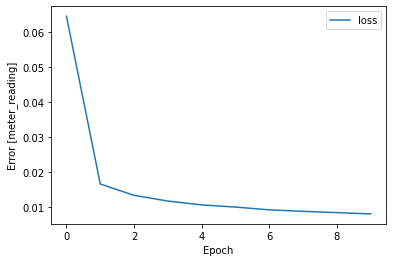

In [13]:
def plot_loss(history):
    plt.plot(history.history['loss'], label='loss')
    plt.xlabel('Epoch')
    plt.ylabel('Error [meter_reading]')
    #plt.ylim((0,500))
    plt.legend()
plot_loss(history)

#### 4.3. Evaluate the model:

In [14]:
cnn_lstm_model.evaluate(
    test_x,
    test_y, verbose=1)

2206/2206 [==============================] - 5s 2ms/step - loss: 0.0047 - mean_squared_error: 0.0047


[0.00466725742444396, 0.00466725742444396]

#### 4.4. Make prediction 1h in advance:

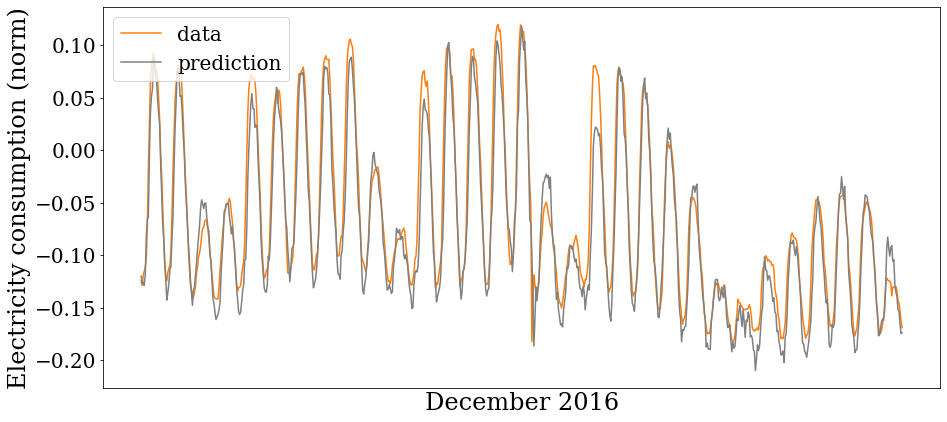

In [28]:
y_hat_clstm = cnn_lstm_model.predict(test_x)
y_hat_last = y_hat_clstm[:,0,:]
y_hat_last.shape

newarr = np.array_split(test_y[:,0,0], 95)
two_blds = np.mean(newarr, axis = 0)
newarrp = np.array_split(y_hat_last[:,0], 95)
two_bldsp = np.mean(newarrp, axis = 0)

plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times New Roman'] + plt.rcParams['font.serif']
figure(figsize =(15,7)) 
plt.plot(two_blds, color = 'C1', label = 'data')
plt.plot(two_bldsp, color = 'gray', label = 'prediction') 
plt.xlabel('December 2016', fontsize = 24)
plt.ylabel('Electricity consumption (norm)', fontsize = 24)
plt.xticks([])
plt.yticks(fontsize = 20)
plt.legend( fontsize = 20, loc = 'upper left')
plt.savefig('CNN_LSTM_1h.pdf', transparency = True,bbox_inches='tight')
plt.show()

##### Calculate metric for this case:

In [17]:
test_data = two_blds
prediction = two_bldsp[:len(two_blds)]
calculate_rmse_metric(test_data,prediction)

0.021869877

#### 4.5 Make prediction 12h in advance:

In [29]:
yhat_tot = make_prediction(test_x, cnn_lstm_model,n_ahead = 12)
yhat_tot.shape

(744,)

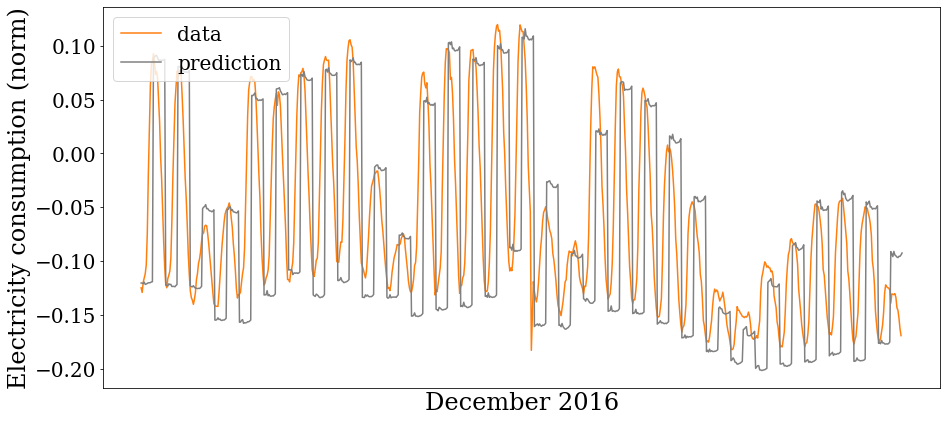

In [30]:
newarr = np.array_split(test_y[:,0,0], 95)
two_blds = np.mean(newarr, axis = 0)
two_bldsp = yhat_tot
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times New Roman'] + plt.rcParams['font.serif']
figure(figsize =(15,7)) 
plt.plot(two_blds, color = 'C1', label = 'data')
plt.plot(two_bldsp, color = 'gray', label = 'prediction') 
plt.xlabel('December 2016', fontsize = 24)
plt.ylabel('Electricity consumption (norm)', fontsize = 24)
plt.xticks([])
plt.yticks(fontsize = 20)
plt.legend( fontsize = 20, loc = 'upper left')
plt.savefig('CNN_LSTM_12h.pdf', transparency = True,bbox_inches='tight')
plt.show()

##### Calculate metric for this case:

In [21]:
test_data = two_blds
prediction = two_bldsp[:len(two_blds)]
calculate_rmse_metric(test_data,prediction)

0.09235427

#### 4.6. Make prediction 24h in advance:

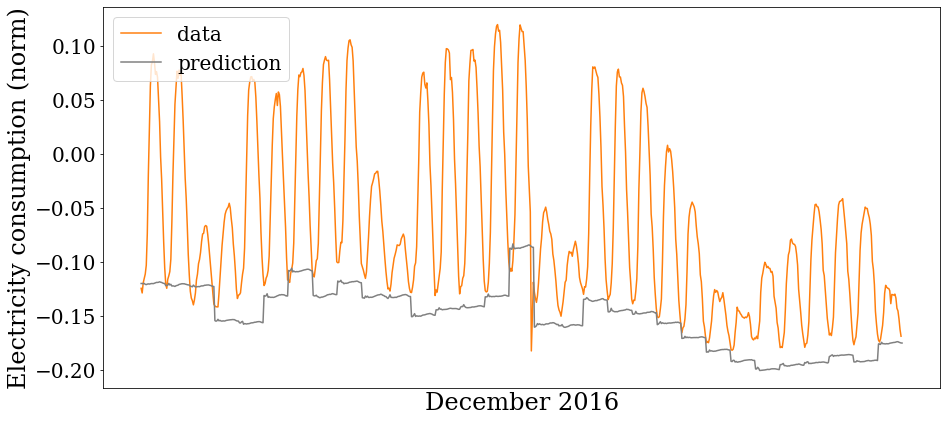

In [31]:
yhat_tot = make_prediction(test_x, cnn_lstm_model,n_ahead = 24)
newarr = np.array_split(test_y[:,0,0], 95)
two_blds = np.mean(newarr, axis = 0)
two_bldsp = yhat_tot
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times New Roman'] + plt.rcParams['font.serif']
figure(figsize =(15,7)) 
plt.plot(two_blds, color = 'C1', label = 'data')
plt.plot(two_bldsp, color = 'gray', label = 'prediction') 
plt.xlabel('December 2016', fontsize = 24)
plt.ylabel('Electricity consumption (norm)', fontsize = 24)
plt.xticks([])
plt.yticks(fontsize = 20)
plt.legend( fontsize = 20, loc = 'upper left')
plt.savefig('CNN_LSTM_24h.pdf', transparency = True,bbox_inches='tight')
plt.show()

##### Calculate metric in this case:

In [25]:
test_data = two_blds
prediction = two_bldsp[:len(two_blds)]
calculate_rmse_metric(test_data,prediction)

0.11097883